In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchvision.transforms import v2
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import cv2
from tqdm import tqdm
import math

In [3]:
IMG_SIZE = 128
device = torch.device('cuda:0')
BUILD_DATASET = False

In [21]:
class CatDogDataset(Dataset):
    def __init__(self, image_path, device='cpu'):
        self.image_path = image_path
        self.device = device
        self.data = []
        # mean and std obtained from documentation
        self.transform = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.load_data()

    def load_data(self):
        for idx, labels in enumerate(os.listdir(self.image_path)):
            print(os.path.join(self.image_path, labels))
            for img_file in tqdm(os.listdir(os.path.join(self.image_path, labels))):
                # read image in BRG
                img_brg = cv2.imread(os.path.join(self.image_path, labels, img_file), cv2.IMREAD_COLOR)
                
                # convert to RGB
                img_rgb = cv2.cvtColor(img_brg, cv2.COLOR_BGR2RGB)
                
                # preprocess image
                img = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
                img = self.transform(img)
                
                # permute image to fit the model cxhxw
                # img = img.permute(2, 1, 0)    # HxCxW -> CxHxW
                
                # laod into gpu
                idx = torch.Tensor([idx])
                self.data.append((img.to(self.device), idx.to(self.device)))

    def __len__(self):
        # return the length of tensor self.data
        return len(self.data)

    def __getitem__(self, idx):
        # returns [image, label] at index=idx
        return self.data[idx]

In [22]:
# build and save
image_path = os.path.join('data', 'training_set')
train_set = CatDogDataset(image_path, device=device)
torch.save(train_set, 'train_data.pth')

image_path = os.path.join('data', 'test_set')
test_set = CatDogDataset(image_path, device=device)
torch.save(test_set, 'test_data.pth')

# load datasets into dataloader
batch_size = 16
train_dl = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_set, batch_size=batch_size, shuffle=False)

data\training_set\cats


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:12<00:00, 332.49it/s]


data\training_set\dogs


100%|█████████████████████████████████████████████████████████████████████████████| 4005/4005 [00:12<00:00, 325.31it/s]


data\test_set\cats


100%|█████████████████████████████████████████████████████████████████████████████| 1011/1011 [00:03<00:00, 335.89it/s]


data\test_set\dogs


100%|█████████████████████████████████████████████████████████████████████████████| 1012/1012 [00:03<00:00, 333.02it/s]


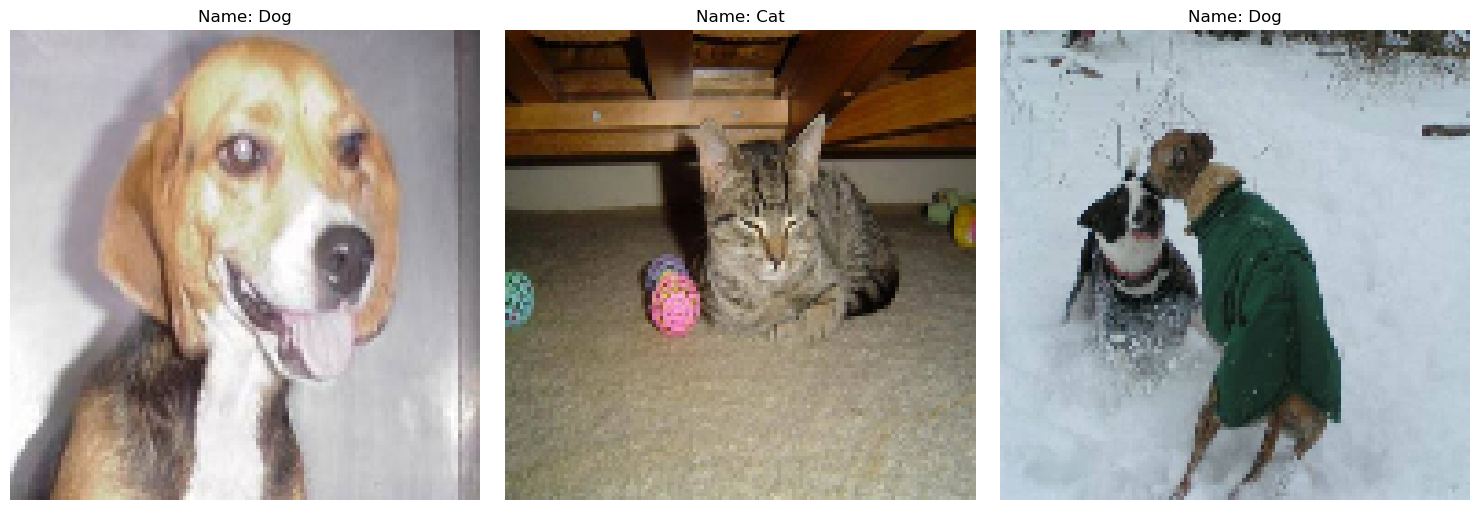

In [26]:
# visualizing tests
img_num = torch.randint(low=0, high=len(train_set), size=(3,1))

num_img = len(img_num)
img_per_row = 3

rows = math.ceil(num_img/img_per_row)
cols = img_per_row

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes = axes.flatten()

for i, idx in enumerate(img_num):
    # load image and its label
    image, label = train_set[idx]
    image = image.cpu()
    
    # de-normalization
    invTrans = v2.Normalize(
            mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
            std = [1/0.229,1/0.224,1/0.225]
    )
    inv_tensor = invTrans(image)
    
    # class prediction
    actual_name = 'Cat' if label.item() == 0 else 'Dog'
    
    # matplot things
    axes[i].imshow(torch.clamp(inv_tensor.permute(1,2,0), 0, 1))
    axes[i].set_title(f'Name: {actual_name}', fontsize=12)
    axes[i].axis('off')

for ax in axes[num_img:]:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [27]:
# googlenet
learning_rate = 0.001
weight_decay = 0.00001

model = models.googlenet(weights='GoogLeNet_Weights.DEFAULT')
# disabling auxillary branches to save vram and train the model at resolution lower than 256x256
model.aux1 = None
model.aux2 = None
# modifying fc layer
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1024),
    nn.LeakyReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(1024, 2),
    nn.LogSoftmax(dim=1)
)
# for name, module in model.named_modules():
#     if name.startswith('fc'):
#         print(name, module)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = nn.NLLLoss()
# print(model)
print(optimizer, loss_fn)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 1e-05
) NLLLoss()


In [16]:
# # inception v3
# learning_rate = 0.001
# weight_decay = 0.00001
# model = models.inception_v3(weights='Inception_V3_Weights.DEFAULT')
# model.AuxLogits = None
# # out_features of inception_v3 in output layer is 1000 but this is only for binary classification
# # in_features: 2048
# model.fc = nn.Sequential(
#     nn.Linear(model.fc.in_features, 1024),
#     nn.LeakyReLU(),
#     nn.Dropout(p=0.2),
#     nn.Linear(1024, 2),
#     nn.LogSoftmax(dim=1)
# )
# # for name, module in model.named_modules():
# #     if name.startswith('fc'):
# #         print(name, module)
# model = model.to(device)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# loss_fn = nn.NLLLoss()
# # print(model)
# print(optimizer, loss_fn)

In [28]:
def train(model):
    epochs = 10
    best_accuracy = 0.0
    
    model.train(True)
    for epoch in range(epochs):
        print(f'Epoch: {epoch+1}')
        running_loss = 0
        running_corrects = 0
        total_entries = 0
        for images, labels in tqdm(train_dl):
            labels = labels.squeeze().long()
            optimizer.zero_grad()
            outputs = model(images)
            # for inception v3
            # loss = loss_fn(outputs[0], labels)
            # for googlenet
            loss = loss_fn(outputs, labels)
            # for inception v3
            # _, prediction = torch.max(outputs[0], 1)
            _, prediction = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum((prediction == labels)).item()
            total_entries += labels.size(0)

        epoch_loss = running_loss / total_entries
        epoch_accuracy = running_corrects / total_entries

        print(f'Epoch Loss: {epoch_loss}, Epoch Accuracy: {epoch_accuracy}')

        if epoch_accuracy > best_accuracy:
            best_accuracy = epoch_accuracy
            torch.save(model.state_dict(), 'googlenet_model.pth')

    print("Training Complete.")


In [29]:
train(model)

Epoch: 1


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [04:03<00:00,  2.06it/s]


Epoch Loss: 0.30036043383641814, Epoch Accuracy: 0.8773266708307308
Epoch: 2


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [04:02<00:00,  2.07it/s]


Epoch Loss: 0.19605038734449587, Epoch Accuracy: 0.9250468457214241
Epoch: 3


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [04:02<00:00,  2.07it/s]


Epoch Loss: 0.17664477686344796, Epoch Accuracy: 0.932417239225484
Epoch: 4


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [04:02<00:00,  2.07it/s]


Epoch Loss: 0.13161906500874573, Epoch Accuracy: 0.9537788881948782
Epoch: 5


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [04:03<00:00,  2.06it/s]


Epoch Loss: 0.12540149854584542, Epoch Accuracy: 0.9527795128044972
Epoch: 6


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [04:02<00:00,  2.06it/s]


Epoch Loss: 0.09715499102942492, Epoch Accuracy: 0.9632729544034978
Epoch: 7


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [04:02<00:00,  2.07it/s]


Epoch Loss: 0.08872172340545931, Epoch Accuracy: 0.9667707682698313
Epoch: 8


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [04:00<00:00,  2.08it/s]


Epoch Loss: 0.14720427180366413, Epoch Accuracy: 0.9491567770143661
Epoch: 9


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [04:00<00:00,  2.08it/s]


Epoch Loss: 0.05689891184342625, Epoch Accuracy: 0.9788881948782011
Epoch: 10


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [04:01<00:00,  2.08it/s]

Epoch Loss: 0.06421982125256404, Epoch Accuracy: 0.9751405371642723
Training Complete.


In [30]:
del model
torch.cuda.empty_cache()

In [31]:
model = models.googlenet()
model.aux1 = None
model.aux2 = None
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1024),
    nn.LeakyReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(1024, 2),
    nn.LogSoftmax(dim=1)
)
model.load_state_dict(torch.load('googlenet_model.pth', map_location=device))
model = model.to(device)

C:\Users\samir\miniconda3\envs\ml\Lib\site-packages\torchvision\models\googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
C:\Users\samir\AppData\Local\Temp\ipykernel_6404\3340671573.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless th

In [32]:
def test(model):
    running_corrects = 0
    model_accuracy = 0
    total_entries = 0
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_dl):
            labels = labels.squeeze().long()

            outputs = model(images)
            _, prediction =  torch.max(outputs, 1)
            running_corrects += torch.sum((prediction == labels)).item()
            total_entries += labels.size(0)
        model_accuracy = running_corrects / total_entries
        print(f'Model Accuracy: {model_accuracy}')

In [33]:
test(model)

100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [00:13<00:00,  9.12it/s]

Model Accuracy: 0.9263470093919921


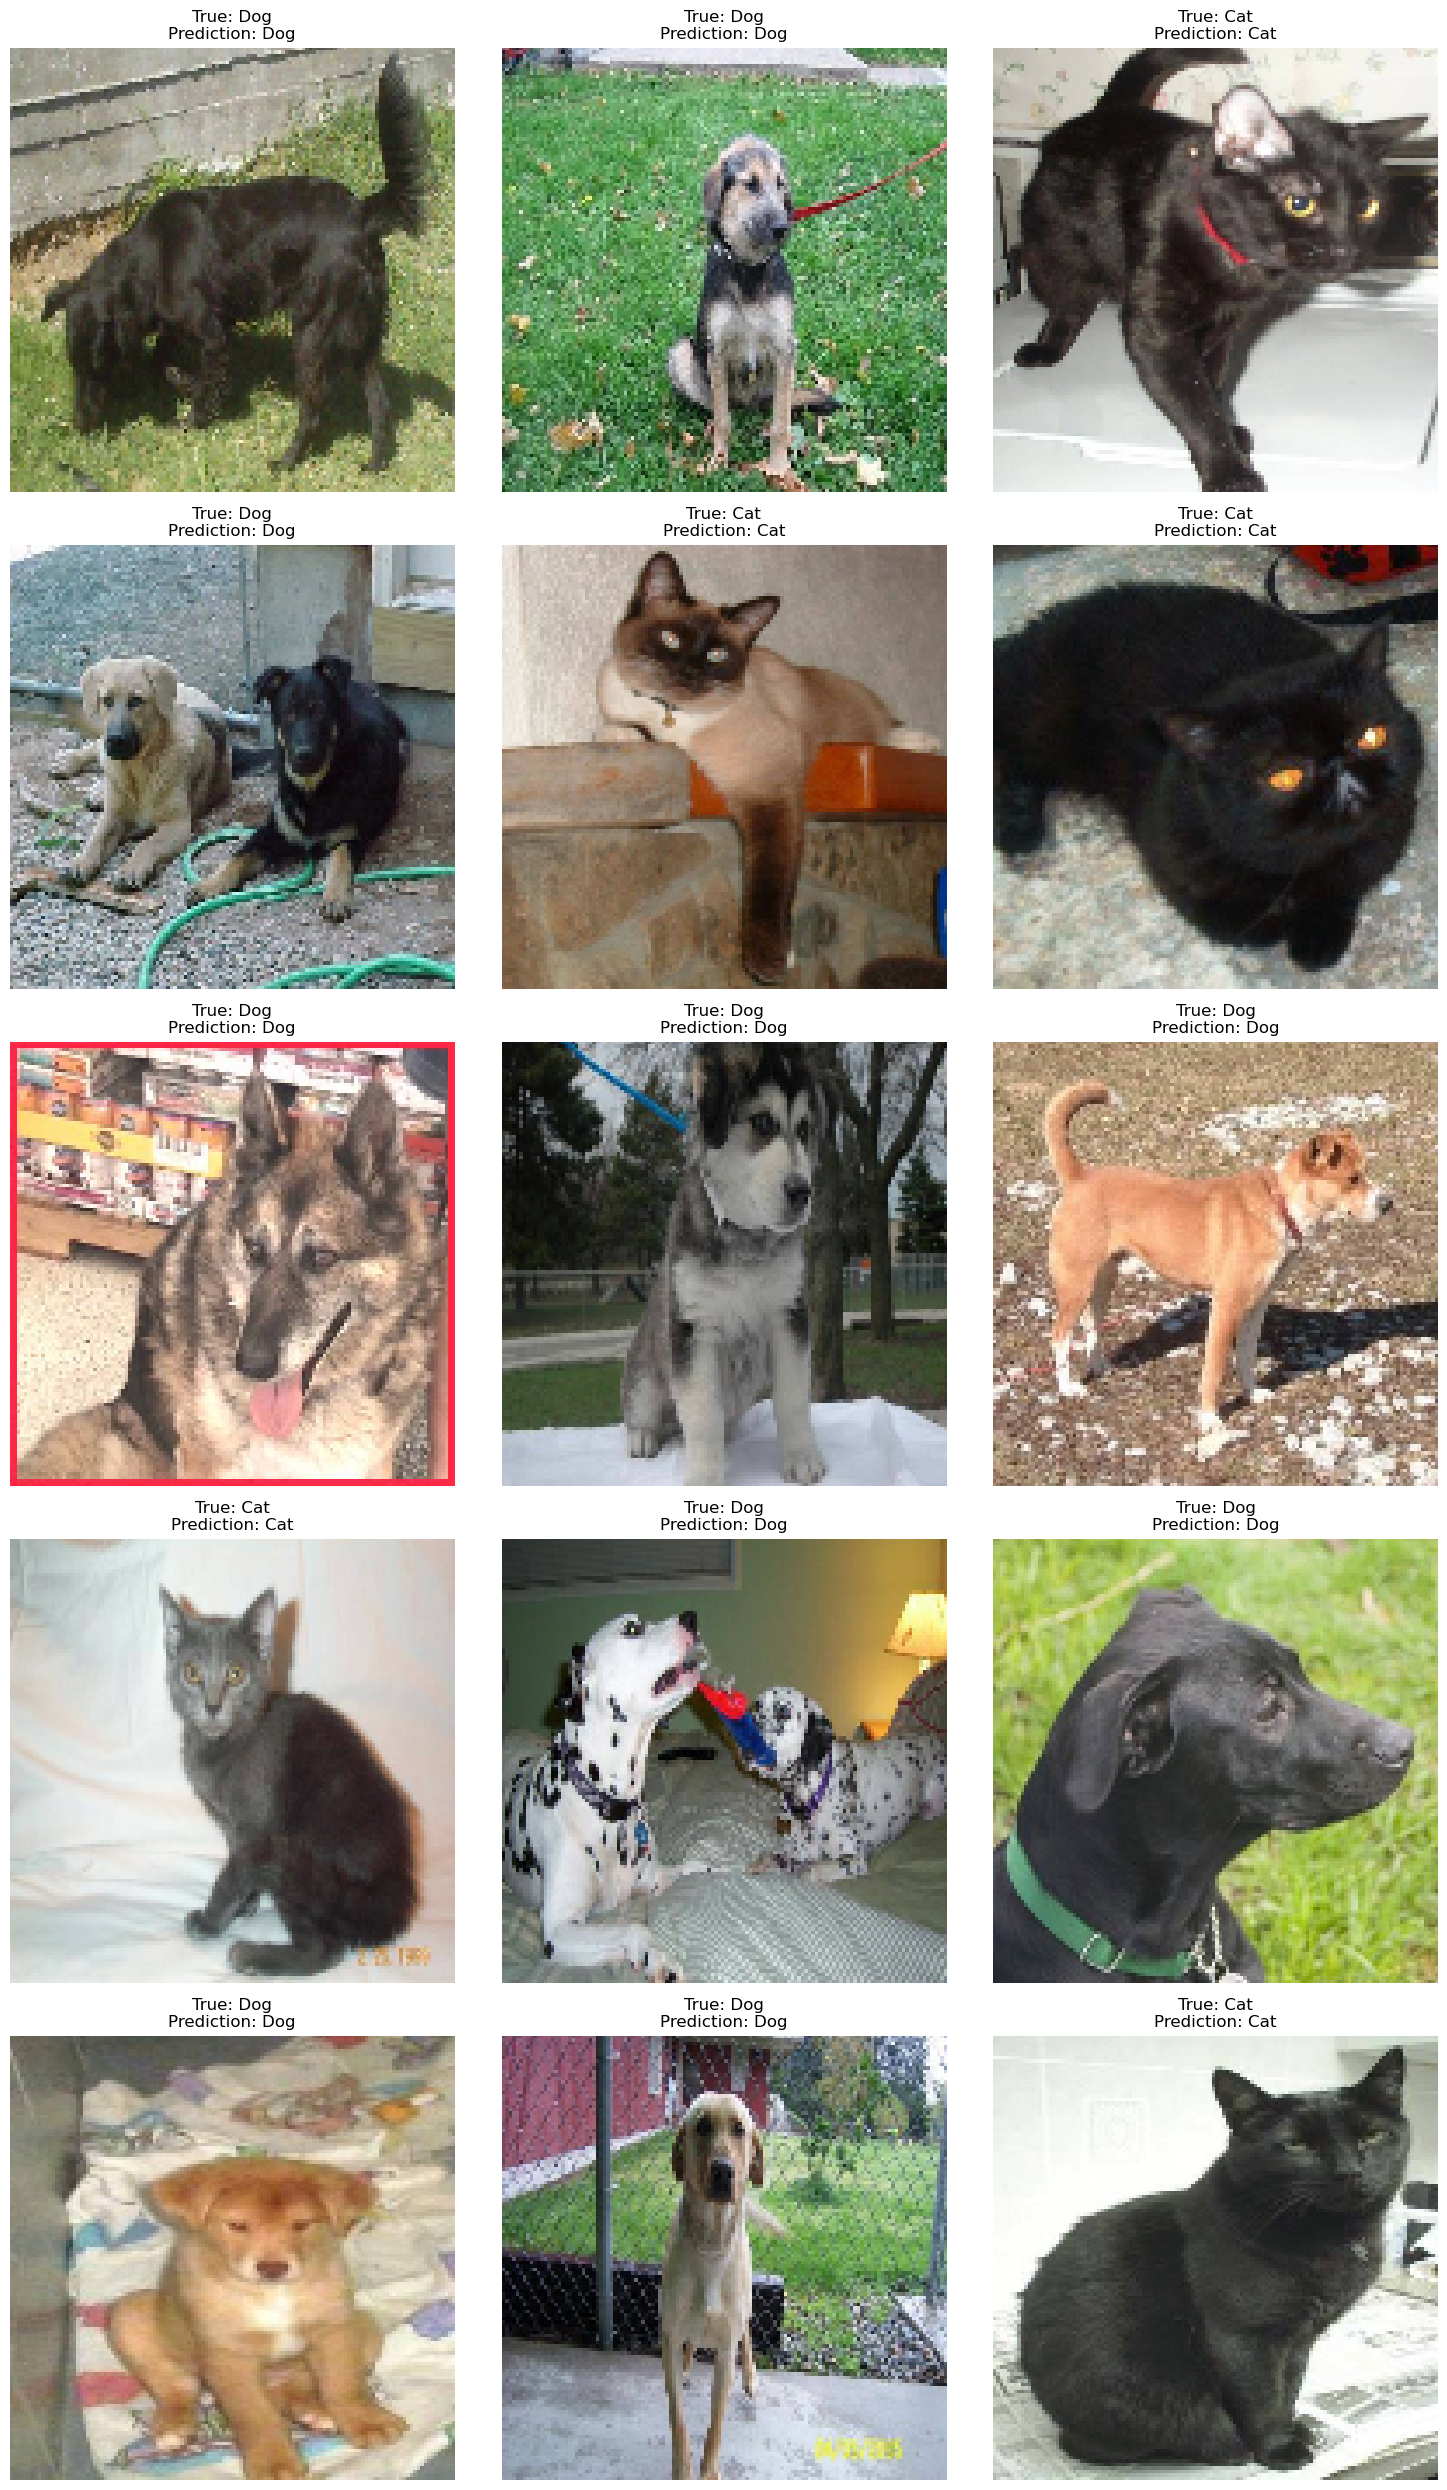

In [34]:
# visualizing tests
img_num = torch.randint(low=0, high=len(test_set), size=(15,1))

num_img = len(img_num)
img_per_row = 3

rows = math.ceil(num_img/img_per_row)
cols = img_per_row

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes = axes.flatten()

model.eval()
for i, idx in enumerate(img_num):
    # load image and its label
    image, label = test_set[idx]
    # convert to 4D [b, c, h, w]
    image = image.unsqueeze(0)
    # prediction
    output = model(image)
    _, prediction = torch.max(output, 1)

    # ready for visualization
    image = image.squeeze(0).cpu()
    
    # de-normalization
    invTrans = v2.Normalize(
            mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
            std = [1/0.229,1/0.224,1/0.225]
    )
    inv_tensor = invTrans(image)
    
    # class prediction
    actual_name = 'Cat' if label.item() == 0 else 'Dog'
    predicted_name = 'Cat' if prediction.item() == 0 else 'Dog'
    
    # matplot things
    axes[i].imshow(torch.clamp(inv_tensor.permute(1,2,0).cpu(), 0, 1))
    axes[i].set_title(f'True: {actual_name}\nPrediction: {predicted_name}', fontsize=12)
    axes[i].axis('off')

for ax in axes[num_img:]:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
image, label = test_set[1]
image = image.cpu()
label = label.cpu().item()

invTrans = v2.Normalize(
            mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
            std = [1/0.229,1/0.224,1/0.225]
)
inv_image = invTrans(image)
inv_image =  torch.clamp(inv_image, 0, 1)

plt.imshow(inv_image.permute(1,2,0))
plt.title(f"Label: {label}")
plt.show()